In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import skimage.transform
import skimage.io
import numpy as np
from sklearn.cluster import KMeans
import random
from PIL import Image
from PIL import ImageFont

import scipy.misc
from PIL import ImageDraw 

In [2]:

def try_composite(a, d, n, s):
    # test the base a to see whether it is a witness for the compositeness of n
    if pow(a, d, n) == 1:
        return False
    for i in range(s):
        if pow(a, 2**i * d, n) == n-1:
            return False
    return True # n is definitely composite

    
def is_probable_prime(n, mrpt_num_trials = 5):
    """
    Miller-Rabin primality test.
 
    A return value of False means n is certainly not prime. A return value of
    True means n is very likely a prime.
 
    >>> is_probable_prime(1)
    Traceback (most recent call last):
        ...
    AssertionError
    >>> is_probable_prime(2)
    True
    >>> is_probable_prime(3)
    True
    >>> is_probable_prime(4)
    False
    >>> is_probable_prime(5)
    True
    >>> is_probable_prime(123456789)
    False
 
    >>> primes_under_1000 = [i for i in range(2, 1000) if is_probable_prime(i)]
    >>> len(primes_under_1000)
    168
    >>> primes_under_1000[-10:]
    [937, 941, 947, 953, 967, 971, 977, 983, 991, 997]
 
    >>> is_probable_prime(6438080068035544392301298549614926991513861075340134\
3291807343952413826484237063006136971539473913409092293733259038472039\
7133335969549256322620979036686633213903952966175107096769180017646161\
851573147596390153)
    True
 
    >>> is_probable_prime(7438080068035544392301298549614926991513861075340134\
3291807343952413826484237063006136971539473913409092293733259038472039\
7133335969549256322620979036686633213903952966175107096769180017646161\
851573147596390153)
    False
    """
    assert n >= 2
    # special case 2
    if n == 2:
        return True
    # ensure n is odd
    if n % 2 == 0:
        return False
    # write n-1 as 2**s * d
    # repeatedly try to divide n-1 by 2
    s = 0
    d = n-1
    while True:
        quotient, remainder = divmod(d, 2)
        if remainder == 1:
            break
        s += 1
        d = quotient
    assert(2**s * d == n-1)
                                     
    for i in range(mrpt_num_trials):
        a = random.randrange(2, n)
        if try_composite(a, d, n, s):
            return False
        

 
    return True # no base tested showed n as composite


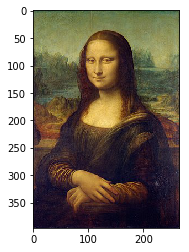

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


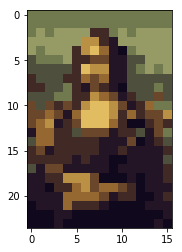

(24, 16, 3)


In [3]:
def get_compressed_image(image):
    orig_shape = image.shape
    image = np.reshape(image, (-1, 3))
    kmeans = KMeans(n_clusters=10).fit(image)

    new_image = np.zeros(image.shape)
    prime_image = np.zeros(image.shape[0], dtype=np.uint8)
    
    for label, center in zip(range(10), kmeans.cluster_centers_):
        new_image[kmeans.labels_==label] = center
        prime_image[kmeans.labels_==label] = label
    new_image = np.reshape(new_image, orig_shape)
    prime_image = np.reshape(prime_image, orig_shape[:2])
    return new_image, prime_image, kmeans


def load_image(filename):
    image = skimage.io.imread(filename)
    image = image.astype(np.float64)
    image = image / 255.
    return image

image = load_image('input_pictures/monalisa.jpg')
plt.imshow(image)
plt.show()


oldshape = image.shape
resized_image = skimage.transform.resize(image, (oldshape[0]//16, oldshape[1]//16))
new_image, prime_image, kmeans = get_compressed_image(resized_image)
plt.imshow(new_image)
plt.show()
print(new_image.shape)

In [4]:

def create_numbered_image(image, kmeans):
    # apply noise
    stdev = np.std(image)
    random_noise = np.random.random_sample(size=image.shape)*(stdev/3)
    image = image + random_noise
    
    orig_shape = image.shape
    image = np.reshape(image, (-1, 3))

    numbered_image = kmeans.predict(image)
    numbered_image = np.reshape(numbered_image, orig_shape[:2])
    
    assert n_image.shape[0] < 50 and "WATCH OUT FOR THE HEIGHT OF IMAGES"
    assert n_image.shape[1] < 50 and "WATCH OUT FOR THE WIDTH OF IMAGES"
    
    # make sure the end is uneven
    if numbered_image[-1,-1]%2==0:
        numbered_image[-1,-1] += 1

    return numbered_image

def numbered_image_to_normal_image(numbered_image, kmeans):
    shape = (numbered_image.shape[0], numbered_image.shape[1], 3)
    image = np.zeros(shape)
    for label, color in zip(range(10), kmeans.cluster_centers_):
        image[numbered_image==label] = color
    return image



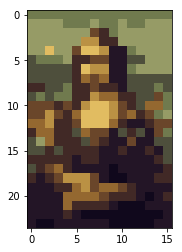

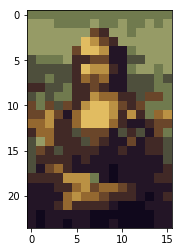

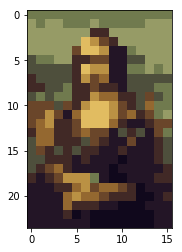

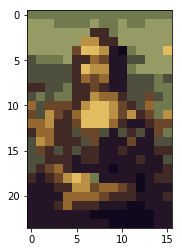

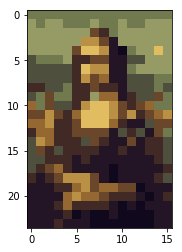

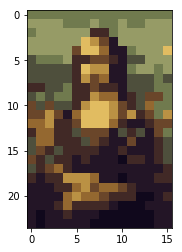

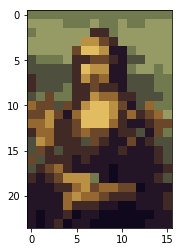

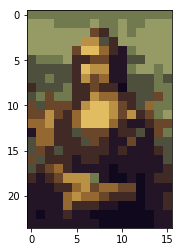

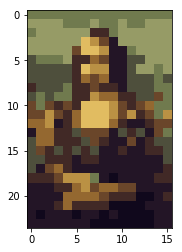

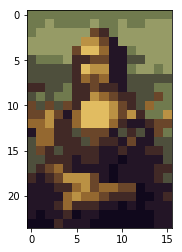

In [5]:

for _ in range(10):
    n_image = create_numbered_image(resized_image, kmeans)
    normal_image = numbered_image_to_normal_image(n_image, kmeans)
    
    plt.imshow(normal_image)
    plt.show()

In [6]:

def image_to_number(numbered_image):
    to_be_number = numbered_image.reshape(-1)
    as_string = ''.join([str(int(x)) for x in to_be_number])
    as_int = int(as_string)
    return as_int, as_string


In [7]:

def show_and_save_image(image, n_image, filename, fontsize=16):
    oldshape = image.shape
    resized_image= scipy.misc.imresize(image,(oldshape[0]*fontsize, oldshape[1]*fontsize), interp='nearest')
    img = Image.fromarray(resized_image).convert("RGBA")
    txt = Image.new('RGBA', img.size, (255,255,255,0))

    draw = ImageDraw.Draw(txt)
    font = ImageFont.truetype("pirulen rg.ttf", fontsize)
    for y_i, totype in enumerate(n_image):
        for x_i, letter in enumerate(totype):
            xpos = x_i * fontsize + 1
            ypos = y_i * fontsize
            if letter == 1:
                xpos += 4
            draw.text((xpos, ypos),str(letter),(255,255,255, 128),font=font)
    img = Image.alpha_composite(img, txt)    

    img.save(filename)
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.show()


In [ ]:
def result_filename(filename):
    return filename.split('.')[0] + "-prime.png"

def is_good_prime_portrait(n_image):
    integer, string = image_to_number(n_image)
    
    if is_probable_prime(integer): 
        return integer, string, n_image
    else:
        return None

In [8]:
folder = 'input_pictures/'

filenames = [
     folder + 'sunflowers.jpg',
]

for filename in filenames:
    image = load_image(filename)
    oldshape = image.shape
    resized_image = skimage.transform.resize(image, (oldshape[0]//16, oldshape[1]//16))
    print("Working with size " + str(resized_image.shape))
    new_image, prime_image, kmeans = get_compressed_image(resized_image)
    plt.imshow(new_image)
    plt.show()
    
    
    for _ in range(10000):
        n_image = create_numbered_image(resized_image, kmeans)    
        
        result = is_good_prime_portrait(n_image)
        if result != None:
            integer, string, n_image = result
            print("-"*100)
            print(string)
            print("-"*100)
            for line in n_image:
                print(''.join([str(x) for x in line]))
            normal_image = numbered_image_to_normal_image(n_image, kmeans)
            plt.imshow(normal_image)
            plt.show()
            show_and_save_image(normal_image, n_image, result_filename(filename))
            break

## Multi threaded attempt


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Working with size (47, 37, 3)


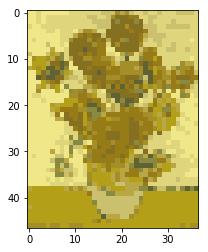

Time spent in (function name) is 26.278046999999997 time per result: 2.6278046999999995
Time spent in (function name) is 46.230549999999994 time per result: 2.3115274999999995
Time spent in (function name) is 61.146881 time per result: 2.0382293666666667
Time spent in (function name) is 72.14596900000001 time per result: 1.8036492250000002
Time spent in (function name) is 93.737995 time per result: 1.8747599
Time spent in (function name) is 120.307063 time per result: 2.0051177166666667
Time spent in (function name) is 139.952835 time per result: 1.9993262142857142
Time spent in (function name) is 158.143188 time per result: 1.97678985
Time spent in (function name) is 167.416934 time per result: 1.8601881555555555
Time spent in (function name) is 189.828087 time per result: 1.89828087
Time spent in (function name) is 207.522333 time per result: 1.8865666636363636
Time spent in (function name) is 219.57185 time per result: 1.8297654166666668
Time spent in (function name) is 237.766034 t

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 684, in next
    item = self._items.popleft()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-4182232ab3ff>", line 29, in <module>
    for result in results:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py", line 688, in next
    self._cond.wait(timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 295, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/inspect.py", line 1411, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/inspect.py", line 666, in getsourcefile
    if getattr(getmodule(object, filename), '__loader__', None) is not None:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/inspect.py", line 712, in getmodule
    os.path.realpath(f)] = module.__name__
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/posixpath.py", line 386, in realpath
    path, ok = _joinrealpath(filename[:0], filename, {})
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/posixpath.py", line 420, in _joinrealpath
    if not islink(newpath):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/posixpath.py", line 169, in islink
    st = os.lstat(path)
KeyboardInterrupt
Traceback (most recent call last):
  

TypeError: must be str, not list

In [10]:
from multiprocessing.dummy import Pool as ThreadPool 
pool = ThreadPool(8) 

def prepare_image(filename):    
    image = load_image(filename)
    oldshape = image.shape
    resized_image = skimage.transform.resize(image, (oldshape[0]//8, oldshape[1]//8))
    print("Working with size " + str(resized_image.shape))
    new_image, prime_image, kmeans = get_compressed_image(resized_image)


prepare_image(filenames[0])

import time
start = time.clock() 


image_generator = (create_numbered_image(resized_image, kmeans) for _ in range(100000))

results = pool.imap_unordered(is_good_prime_portrait, image_generator)
total_results = 0
for result in results:
    total_results += 1
    if total_results%10==0:
        elapsed = time.clock()
        elapsed = elapsed - start
        print("Time spent in (function name) is {} time per result: {}".format(str(elapsed), str(elapsed/total_results)))
        
    if result != None:
        integer, string, n_image = result
        
        print("-"*100)
        print(string)
        print("-"*100)
        for line in n_image:
            print(''.join([str(x) for x in line]))
        normal_image = numbered_image_to_normal_image(n_image, kmeans)
        plt.imshow(normal_image)
        plt.show()
        show_and_save_image(normal_image, n_image, result_filename(filename))
        break


## How does this scale

Appartenlty the largest known prime number is 22338618 long (http://primes.utm.edu/largest.html). This would allow us to create a 4726 * 4726 prime portrait, which means that prime portraits in 4K resolution are viable :D



In [ ]:
def trials_needed_img(w,h):
    return 2.3*w*h

needed = [trials_needed_img(x,x) for x in range(1,300)]
plt.plot(needed)

## Can we create a prime movie? 
The Solitude of Prime Numbers - Wikipedia